In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os

import tensorflow as tf
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics

import wandb
from wandb.keras import WandbCallback

#custom packages
from models import createSimpleModel
from landscapes import *

In [29]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


Referencing: https://arxiv.org/pdf/2212.11285.pdf

We start off by loading in 1,000,000 background dijet events and 100,000 signal dijet events. The signal comes from the process Z$\rightarrow$ X($\rightarrow$ $q\bar{q}$) Y$\rightarrow$($q\bar{q}$) where Z is 3.5 TeV. X is 500 GeV and Y is 100 GeV. 

In [3]:
dir_path = "/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5"
df_test = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5")
df_test

,0,1,2,3,4,5,6,7,8,9,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,0.324101,-0.361158,2.737669,0.409859,-2.429939,0.729830,0.867922,-2.267777,-1.161310,0.383031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.646304,-0.539460,-1.386258,0.471293,-1.636572,0.751657,0.453769,-1.099593,-0.393405,0.485929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.325172,-0.833948,2.404844,1.295058,-2.089618,-1.873342,0.451272,-0.101877,2.217348,0.461293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.290918,-2.200063,1.630132,0.565028,-1.714345,-2.617103,0.951042,-0.532720,2.941473,0.896248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.526330,-2.349110,-1.745532,0.542491,-2.080352,-3.044045,0.390727,-1.278563,-2.131058,2.530358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099995,0.372368,-1.283898,2.680089,0.511526,-0.216247,1.011824,0.440795,-1.860590,1.395164,1.483386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099996,0.587996,-2.347485,0.104980,0.325682,-1.943584,-2.330028,0.700224,-2.161175,0.136797,0.550588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099997,0.631419,-0.597308,-2.114541,3.165008,-0.968924,-0.729551,4.613834,-0.989630,-0.724770,3.701483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099998,5.084272,-1.004487,1.772670,4.767743,-0.878143,1.713857,10.833469,-0.934815,1.795471,10.265807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
df_QCD

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1467.239990,611.502014,511.101990,38.896000,8.290650,4.836080,4.260190,1403.579956,-674.551025,-451.670990,237.893997,79.815102,21.010300,16.757601
1,-1211.239990,347.315002,547.963013,389.532013,191.804001,99.562798,70.872200,619.341003,-62.177299,-1944.040039,22.999201,8.042180,6.335090,5.525370
2,-1229.619995,649.857971,8.089170,72.155502,47.168098,37.243198,33.658199,1196.250000,-647.896973,-1283.109985,78.230698,15.292900,13.944200,10.013500
3,-693.304016,-1046.729980,1716.910034,55.797798,24.788500,6.890140,5.813400,747.961975,994.250000,-412.966003,359.113007,175.209000,103.500999,84.447098
4,-1488.199951,-25.370100,-30.989700,84.891502,26.878799,15.517200,13.260400,1415.640015,20.905100,223.630997,77.506500,57.986000,34.147400,26.660601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,-646.442017,-1295.150024,1331.800049,37.011299,21.006800,12.873700,8.898860,274.566986,1019.390015,-504.290985,90.375000,61.218800,20.514500,15.854600
999995,-286.550995,-1310.829956,-1510.910034,147.516998,60.997799,41.356201,28.225700,252.884995,1085.420044,759.314026,58.769901,42.276402,8.637120,7.852020
999996,918.562988,951.195984,-1622.569946,32.242199,5.894110,5.004100,3.992740,-266.285004,-1284.189941,185.007996,136.389008,70.623901,49.508499,40.708599
999997,1447.219971,-547.710999,827.945007,396.112000,181.406998,152.207993,86.676804,-932.369995,165.005005,-2806.959961,56.471600,14.446400,10.258900,8.874700


In [10]:
df = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")

In [16]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1698.670044,-884.039978,723.843018,105.035004,83.721703,46.282101,13.635700,1539.439941,372.238007,-295.865997,461.574005,431.343994,52.344799,37.284901
1,1246.660034,-1133.010010,-921.987000,159.865997,133.781998,58.968601,30.377399,-1218.489990,1108.380005,182.147003,514.883972,462.654999,138.789001,67.805801
2,420.975006,-1739.790039,281.553986,93.665901,77.925797,10.605900,6.916520,-510.779999,1484.069946,227.175995,475.316986,217.113998,29.424000,21.020300
3,161.048996,-1664.859985,-2005.099976,116.327003,61.819698,38.143600,18.414400,-188.942993,1556.900024,-561.664001,561.236023,348.181000,102.625000,53.422699
4,-564.754028,-1315.599976,-1087.410034,513.015991,276.446991,50.629799,35.460999,326.164001,1050.239990,1201.000000,108.752998,89.666603,40.928699,17.055799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,-206.662003,-1729.280029,357.635010,96.165001,58.014500,11.731300,6.174070,218.800003,1714.890015,-210.578995,472.475006,259.884003,40.806999,31.226000
99995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.890999,21.177200,10.582400,9.138590
99996,-1286.619995,-86.162598,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502
99997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726601,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301


Text(0.5, 1.0, 'Jet Mass Distributions')

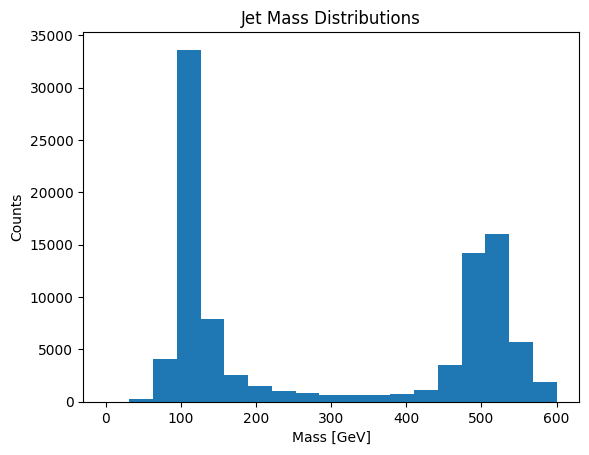

In [65]:
plt.hist(df['mj1'],bins=np.linspace(0,600,20))
plt.xlabel("Mass [GeV]")
plt.ylabel("Counts")
plt.title("Jet Mass Distributions")

In [21]:
def computemjj_pd(event):
    px1 = event[["pxj1"]].to_numpy()
    py1 = event[["pyj1"]].to_numpy()
    pz1 = event[["pzj1"]].to_numpy()
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+event[["mj1"]].to_numpy()**2)
    
    px2 = event[["pxj2"]].to_numpy()
    py2 = event[["pyj2"]].to_numpy()
    pz2 = event[["pzj2"]].to_numpy()
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+event[["mj2"]].to_numpy()**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [22]:
computemjj_pd(df_QCD)

array([3307.21938744, 3107.62060343, 3004.89527209, ..., 3021.08344341,
       4283.54500244, 2784.05801619])

In [5]:
def computemjj_txt(event):
    pT1 = np.array([float(event[2*i][0]) for i in range(int(len(event)/2))])
    eta1 = np.array([float(event[2*i][1]) for i in range(int(len(event)/2))])
    phi1 = np.array([float(event[2*i][2]) for i in range(int(len(event)/2))])
    m1 = np.array([float(event[2*i][3]) for i in range(int(len(event)/2))])
    px1 = pT1*np.cos(phi1)
    py1 = pT1*np.sin(phi1)
    pz1 = pT1*np.sinh(eta1)
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+m1**2)
    
    pT2 = np.array([float(event[2*i+1][0]) for i in range(int(len(event)/2))])
    eta2 = np.array([float(event[2*i+1][1]) for i in range(int(len(event)/2))])
    phi2 = np.array([float(event[2*i+1][2]) for i in range(int(len(event)/2))])
    m2 = np.array([float(event[2*i+1][3]) for i in range(int(len(event)/2))])
    px2 = pT2*np.cos(phi2)
    py2 = pT2*np.sin(phi2)
    pz2 = pT2*np.sinh(eta2)
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+m2**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [4]:
mj1_list = []
mj2_list = []
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]

epsilon = 1e-4
if (False):
    lmass_vec = {}
    x = {}
    mjjs = {}

    mu_m = 0.
    mu_t = 0.
    sd_m = 0.
    sd_t = 0.

    for m1 in mass_range:
        for m2 in mass_range:

            print("on ...",m1,m2)

            ltau1_m_m = []
            ltau2_m_m = []
            stau1_m_m = []
            stau2_m_m = []
            if (m1>0 and m2>0):
                myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                jets_m_m = []
                for line in myfile:
                    jets_m_m+=[line.split("J")[1].split("P")[0].split()]
                    pass
                                    
                ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
                sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

                lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
                smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.

                #check ordering of the leading and subleading jets
                #if leading jet mm > subleading, continue
                #if leading jet mm < subleading, swap
                for i in range(int(len(lmass_m_m))):
                    if lmass_m_m[i] > smass_m_m[i]:
                        continue
                    elif lmass_m_m[i] < smass_m_m[i]:
                        lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]
                
                ltau1_m_m = np.array([float(ljet_m_m[i][5]) for i in range(len(ljet_m_m))])
                ltau2_m_m = np.array([float(ljet_m_m[i][6]) for i in range(len(ljet_m_m))])

                stau1_m_m = np.array([float(sjet_m_m[i][5]) for i in range(len(ljet_m_m))])
                stau2_m_m = np.array([float(sjet_m_m[i][6]) for i in range(len(ljet_m_m))])

                mjj = computemjj_txt(jets_m_m)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]
                pass
            elif m1==0 and m2==0:
                df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
                lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
                smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.
                
                #check jet ordering
                for i in range(int(len(lmass_m_m))):
                    if lmass_m_m[i] > smass_m_m[i]:
                        continue
                    elif lmass_m_m[i] < smass_m_m[i]:
                        lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]
                        
                ltau1_m_m = np.array(df_QCD[["tau1j1"]]).flatten()
                ltau2_m_m = np.array(df_QCD[["tau2j1"]]).flatten()
                stau1_m_m = np.array(df_QCD[["tau1j2"]]).flatten()
                stau2_m_m = np.array(df_QCD[["tau2j2"]]).flatten()
                mjj = computemjj_pd(df_QCD)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]

                mu_m = np.mean(lmass_m_m)
                mu_t = np.mean(ltau2_m_m/(ltau1_m_m+0.0001))
                sd_m = np.std(lmass_m_m)
                sd_t = np.std(ltau2_m_m/(ltau1_m_m+0.0001))
                pass
            else:
                continue

            ms = np.stack([lmass_m_m,smass_m_m],axis=1)
            ts = np.stack([ltau2_m_m/(ltau1_m_m+0.0001),stau2_m_m/(stau1_m_m+0.0001)],axis=1)
            order1 = [np.argmin(ms[i]) for i in range(len(ms))]
            order2 = [np.argmax(ms[i]) for i in range(len(ms))]
            mJ1 = np.array([ms[i][order1[i]] for i in range(len(ms))])
            mJ2 = np.array([ms[i][order2[i]] for i in range(len(ms))])
            
            #testing to see if jets sorted properly
            mj1_list.append(mJ1)
            mj2_list.append(mJ2)
            
            x[m1,m2] = np.stack([(mJ2 - mu_m)/sd_m,
                                    ((mJ1 - mJ2) - mu_m)/sd_m,
                                    ([ts[i][order2[i]] for i in range(len(ts))] - mu_t)/sd_t,
                                    ([ts[i][order1[i]] for i in range(len(ts))] - mu_t)/sd_t],axis=1)
            lmass_vec[m1,m2]=lmass_m_m
            pass
        pass

    x_array = []
    for m1 in mass_range:
        for m2 in mass_range:
            if (m1==0 and m2>0 or m2==0 and m1>0):
                continue
            x_array+=[x[m1,m2]]
    #np.save("x_array_order42", x_array)

In [165]:
count = 0
mass_pairs = []
for m1 in mass_range[1:]:
    for m2 in mass_range[1:]:
        mass_pairs.append((m1, m2))
                          
        count+=1
    
print(count)

144


In [181]:
count = 0
for i in range(len(mj1_list)):
    if mj1_list[17][i] > mj2_list[12][i]:
        #print("greater")
        count+=1
print(f"{count} instances of mj1 > mj2")

3 instances of mj1 > mj2


In [ ]:
def load_data(filename, noise_dims):

    mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
    x = {}
    x_array_read = np.load(filename,allow_pickle=True)
    mycounter = -1
    for m1 in mass_range:
        for m2 in mass_range:
            for qq in ['qq']:
                if (m1==0 and m2>0 or m2==0 and m1>0):
                    continue
                mycounter+=1
                x[m1,m2,qq, False] = x_array_read[mycounter]

                if noise_dims:
                    qq = "qq"
                    for i in range(noise_dims):
                        noise_feature = np.random.normal(0, 1, len(x[m1,m2,qq, False])).reshape(-1, 1)
                        if i == 0:
                            x[m1, m2, qq, True] = np.hstack((x[m1,m2, qq, False], noise_feature))
                        if i > 0:
                            x[m1, m2, qq, True] = np.hstack((x[m1,m2, qq, True], noise_feature))
    
    return x
            
x = load_data("x_array_order.npy", noise_dims = 10)

In [5]:
x = {}
x_array_read = np.load("x_array_order.npy",allow_pickle=True)
mycounter = -1
for m1 in mass_range:
    for m2 in mass_range:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        mycounter+=1
        x[m1,m2] = x_array_read[mycounter]

In [4]:
np.shape(x[0,0])

(121352, 4)

In [5]:
x_data = np.concatenate([x[0,0],x[1,1]])
y_data = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[1,1]))])
X_train, X_val, Y_train, Y_val = train_test_split(x_data, y_data, test_size=0.5)

In [142]:
pscratch_dir = "/pscratch/sd/g/gupsingh"
os.environ["WANDB_DIR"] = pscratch_dir

wandb.init(
    project="Anomaly",
    group="Dedicated_Fixed",
    entity='gup-singh',
    mode = 'online',

    config={
        "layer_1": 512,
        "activation_1": "relu",
        "layer_2": 256,
        "activation_2": "relu",
        "layer_3": 128,
        "activation_3": "relu",
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 1000,
        "batch_size": 1024,
    },
    dir=pscratch_dir
)

config = wandb.config

In [143]:
model_dedicated = Sequential()
model_dedicated.add(Dense(config.layer_1, input_dim=4, activation=config.activation_1))
#model_dedicated.add(Dropout(config.dropout_rate_1))
model_dedicated.add(Dense(config.layer_2, activation=config.activation_2))
model_dedicated.add(Dense(config.layer_3, activation=config.activation_3))
model_dedicated.add(Dense(config.output_layer, activation=config.output_activation))
model_dedicated.compile(loss=config.loss, optimizer=config.optimizer, metrics=[config.metric])
model_dedicated.summary()

Model: "sequential_121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_793 (Dense)           (None, 512)               2560      
                                                                 
 dense_794 (Dense)           (None, 256)               131328    
                                                                 
 dense_795 (Dense)           (None, 128)               32896     
                                                                 
 dense_796 (Dense)           (None, 1)                 129       
                                                                 
Total params: 166,913
Trainable params: 166,913
Non-trainable params: 0
_________________________________________________________________


In [144]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [145]:
myhistory = model_dedicated.fit(X_train, Y_train, epochs=config.epoch,
                                validation_data=(X_val, Y_val),
                                batch_size=config.batch_size, callbacks=[WandbCallback(), es])

Epoch 1/1000
63/88 [====================>.........] - ETA: 0s - loss: 0.3180 - accuracy: 0.8799INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 12ms/step - loss: 0.3036 - accuracy: 0.8853 - val_loss: 0.2607 - val_accuracy: 0.9031
Epoch 2/1000
64/88 [====================>.........] - ETA: 0s - loss: 0.2531 - accuracy: 0.9063INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 11ms/step - loss: 0.2516 - accuracy: 0.9065 - val_loss: 0.2499 - val_accuracy: 0.9049
Epoch 3/1000
66/88 [=====================>........] - ETA: 0s - loss: 0.2363 - accuracy: 0.9108INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 12ms/step - loss: 0.2348 - accuracy: 0.9113 - val_loss: 0.2252 - val_accuracy: 0.9155
Epoch 4/1000
84/88 [===========================>..] - ETA: 0s - loss: 0.2180 - accuracy: 0.9179INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 12ms/step - loss: 0.2176 - accuracy: 0.9181 - val_loss: 0.2097 - val_accuracy: 0.9225
Epoch 5/1000
80/88 [==========================>...] - ETA: 0s - loss: 0.2073 - accuracy: 0.9211INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 12ms/step - loss: 0.2065 - accuracy: 0.9216 - val_loss: 0.2044 - val_accuracy: 0.9248
Epoch 6/1000
85/88 [===========================>..] - ETA: 0s - loss: 0.2017 - accuracy: 0.9241INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 11ms/step - loss: 0.2014 - accuracy: 0.9241 - val_loss: 0.2038 - val_accuracy: 0.9255
Epoch 7/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.2013 - accuracy: 0.9242 - val_loss: 0.2068 - val_accuracy: 0.9226
Epoch 8/1000
61/88 [===================>..........] - ETA: 0s - loss: 0.1993 - accuracy: 0.9246INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 11ms/step - loss: 0.1980 - accuracy: 0.9251 - val_loss: 0.1993 - val_accuracy: 0.9258
Epoch 9/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1968 - accuracy: 0.9258 - val_loss: 0.2035 - val_accuracy: 0.9242
Epoch 10/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1968 - accuracy: 0.9256 - val_loss: 0.2029 - val_accuracy: 0.9249
Epoch 11/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1969 - accuracy: 0.9257 - val_loss: 0.2013 - val_accuracy: 0.9257
Epoch 12/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1971 - accuracy: 0.9254 - val_loss: 0.2036 - val_accuracy: 0.9241
Epoch 13/1000
67/88 [=====================>........] - ETA: 0s - loss: 0.1971 - accuracy: 0.9253INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 11ms/step - loss: 0.1981 - accuracy: 0.9246 - val_loss: 0.1992 - val_accuracy: 0.9258
Epoch 14/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1963 - accuracy: 0.9262 - val_loss: 0.2000 - val_accuracy: 0.9258
Epoch 15/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1965 - accuracy: 0.9262 - val_loss: 0.1994 - val_accuracy: 0.9262
Epoch 16/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1960 - accuracy: 0.9259 - val_loss: 0.2019 - val_accuracy: 0.9250
Epoch 17/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1972 - accuracy: 0.9254 - val_loss: 0.1992 - val_accuracy: 0.9262
Epoch 18/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1953 - accuracy: 0.9260 - val_loss: 0.2009 - val_accuracy: 0.9248
Epoch 19/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1966 - accuracy: 0.9252 - val_loss: 0.1996 - val_accuracy: 0.9262
Epoch 20/100

wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 10ms/step - loss: 0.1949 - accuracy: 0.9267 - val_loss: 0.1986 - val_accuracy: 0.9260
Epoch 21/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1957 - accuracy: 0.9266 - val_loss: 0.2000 - val_accuracy: 0.9252
Epoch 22/1000
62/88 [====================>.........] - ETA: 0s - loss: 0.1952 - accuracy: 0.9264INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 11ms/step - loss: 0.1948 - accuracy: 0.9267 - val_loss: 0.1985 - val_accuracy: 0.9265
Epoch 23/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1939 - accuracy: 0.9268 - val_loss: 0.1988 - val_accuracy: 0.9261
Epoch 24/1000
60/88 [===================>..........] - ETA: 0s - loss: 0.1926 - accuracy: 0.9268INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 2s 21ms/step - loss: 0.1938 - accuracy: 0.9268 - val_loss: 0.1983 - val_accuracy: 0.9266
Epoch 25/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1946 - accuracy: 0.9264 - val_loss: 0.2032 - val_accuracy: 0.9245
Epoch 26/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1948 - accuracy: 0.9265 - val_loss: 0.1987 - val_accuracy: 0.9261
Epoch 27/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1943 - accuracy: 0.9266 - val_loss: 0.1986 - val_accuracy: 0.9265
Epoch 28/1000
61/88 [===================>..........] - ETA: 0s - loss: 0.1921 - accuracy: 0.9267INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 11ms/step - loss: 0.1938 - accuracy: 0.9265 - val_loss: 0.1976 - val_accuracy: 0.9264
Epoch 29/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.1943 - accuracy: 0.9268 - val_loss: 0.1991 - val_accuracy: 0.9258
Epoch 30/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1934 - accuracy: 0.9270 - val_loss: 0.1976 - val_accuracy: 0.9260
Epoch 31/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1940 - accuracy: 0.9268 - val_loss: 0.1990 - val_accuracy: 0.9259
Epoch 32/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.1931 - accuracy: 0.9268 - val_loss: 0.2001 - val_accuracy: 0.9253
Epoch 33/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1944 - accuracy: 0.9267 - val_loss: 0.1988 - val_accuracy: 0.9264
Epoch 34/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1935 - accuracy: 0.9272 - val_loss: 0.1987 - val_accuracy: 0.9260
Epoch 35/100

wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231127_141223-xxg2tcyt/files/model-best)... Done. 0.0s


88/88 [==============================] - 1s 11ms/step - loss: 0.1928 - accuracy: 0.9272 - val_loss: 0.1976 - val_accuracy: 0.9266
Epoch 36/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1936 - accuracy: 0.9265 - val_loss: 0.2019 - val_accuracy: 0.9245
Epoch 37/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1929 - accuracy: 0.9271 - val_loss: 0.1982 - val_accuracy: 0.9262
Epoch 38/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1934 - accuracy: 0.9264 - val_loss: 0.1998 - val_accuracy: 0.9253
Epoch 39/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1933 - accuracy: 0.9272 - val_loss: 0.1980 - val_accuracy: 0.9266
Epoch 40/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1932 - accuracy: 0.9269 - val_loss: 0.2002 - val_accuracy: 0.9250
Epoch 41/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.1933 - accuracy: 0.9267 - val_loss: 0.1991 - val_accuracy: 0.9258
Epoch 42/100

In [146]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▄▅▆▇▇▇████▇████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▅▇▇█▇█▇█▇███▇███▇███▇████████████▇████
val_loss,█▇▄▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.92785
best_epoch,34
best_val_loss,0.1976
epoch,44
loss,0.19201
val_accuracy,0.9261


In [117]:
y_val_pred = model_dedicated.predict(X_val)
auc = roc_auc_score(Y_val, y_val_pred)

print("AUC:", auc)

2806/2806 [==============================] - 2s 754us/step
AUC: 0.9696640331901925


In [7]:
model_dedicated = Sequential()
model_dedicated.add(Dense(128, input_dim=4, activation='relu'))
model_dedicated.add(Dense(128, activation='relu'))
model_dedicated.add(Dense(128, activation='relu'))
model_dedicated.add(Dense(1, activation='sigmoid'))
model_dedicated.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

2023-11-15 14:26:47.851303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 14:26:48.528032: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12293 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [9]:
myhistory = model_dedicated.fit(X_train_100, Y_train_100, epochs=100,validation_data=(X_val_100, Y_val_100),batch_size=1024)

Epoch 1/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1931 - accuracy: 0.9190 - val_loss: 0.1905 - val_accuracy: 0.9201
Epoch 2/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1921 - accuracy: 0.9194 - val_loss: 0.1890 - val_accuracy: 0.9206
Epoch 3/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1920 - accuracy: 0.9198 - val_loss: 0.1891 - val_accuracy: 0.9208
Epoch 4/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1929 - accuracy: 0.9191 - val_loss: 0.1888 - val_accuracy: 0.9213
Epoch 5/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1918 - accuracy: 0.9199 - val_loss: 0.1884 - val_accuracy: 0.9211
Epoch 6/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1925 - accuracy: 0.9190 - val_loss: 0.1893 - val_accuracy: 0.9207
Epoch 7/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1919 - accuracy: 0.9195 - val_loss: 0.1883 - val_accuracy: 0.9206

In [34]:
wandb.finish()

In [53]:
#model_dedicated.save("model_100_BCE")

INFO:tensorflow:Assets written to: model_100_BCE/assets


In [79]:
preds_mm_list = []

tuple_rates_dedicated_ordered_BCE = {}

for i in mass_range[1:]:
    for j in mass_range[1:]:
        if (i == 0.5 and j == 0.5) or (i == 1 and j == 1) or (i == 2 and j == 2) or (i == 3 and j == 3) or (i == 4 and j == 4) or (i == 5 and j == 5) or (i == 6 and j == 6):
            x_vals_mm = np.concatenate([x[0,0],x[i,j]])
            y_vals_mm = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[i,j]))])
            X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(x_vals_mm, y_vals_mm, test_size=0.5)

            model = Sequential()
            model.add(Dense(512, input_dim=4, activation='relu'))
            model.add(Dense(256, activation='relu'))
            model.add(Dense(128, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

            myhistory = model.fit(X_train_mm, Y_train_mm, epochs=1000, validation_data=(X_val_mm, Y_val_mm),batch_size=1024, callbacks = [es])

            preds_mm = model.predict(X_val_mm,batch_size=1000)
            fpr_mm, tpr_mm, _ = metrics.roc_curve(Y_val_mm, preds_mm)

            preds_mm_list.append(preds_mm)
            tuple_rates_dedicated_ordered_BCE[tuple((i, j))] = [fpr_mm, tpr_mm]

Epoch 1/1000
97/97 [==============================] - 1s 4ms/step - loss: 0.3718 - accuracy: 0.8337 - val_loss: 0.3105 - val_accuracy: 0.8645
Epoch 2/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.3054 - accuracy: 0.8652 - val_loss: 0.2977 - val_accuracy: 0.8689
Epoch 3/1000
97/97 [==============================] - 0s 4ms/step - loss: 0.2968 - accuracy: 0.8679 - val_loss: 0.2928 - val_accuracy: 0.8708
Epoch 4/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.2936 - accuracy: 0.8692 - val_loss: 0.2947 - val_accuracy: 0.8698
Epoch 5/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.2939 - accuracy: 0.8695 - val_loss: 0.2888 - val_accuracy: 0.8726
Epoch 6/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.2924 - accuracy: 0.8706 - val_loss: 0.2896 - val_accuracy: 0.8727
Epoch 7/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.2922 - accuracy: 0.8703 - val_loss: 0.2978 - val_accuracy: 0.8688
Epoch 

In [77]:
len(tuple_rates_dedicated_ordered_BCE)

6

In [80]:
np.save("tuple_rates_dedicated_ordered_BCE", tuple_rates_dedicated_ordered_BCE)

In [55]:
model_all_BCE = tf.keras.models.load_model('model_all_BCE')

In [81]:
tuple_rates_dedicated = np.load("tuple_rates_dedicated_ordered_BCE.npy", allow_pickle = True).item()
len(tuple_rates_dedicated)

7

In [78]:
tuple_rates_dedicated.keys()

dict_keys([(0.5, 0.5), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)])

183/183 [==============================] - 0s 690us/step


/tmp/ipykernel_1856354/1929924636.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


183/183 [==============================] - 0s 653us/step


/tmp/ipykernel_1856354/1929924636.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


183/183 [==============================] - 0s 664us/step


/tmp/ipykernel_1856354/1929924636.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


183/183 [==============================] - 0s 670us/step


/tmp/ipykernel_1856354/1929924636.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


183/183 [==============================] - 0s 667us/step


/tmp/ipykernel_1856354/1929924636.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


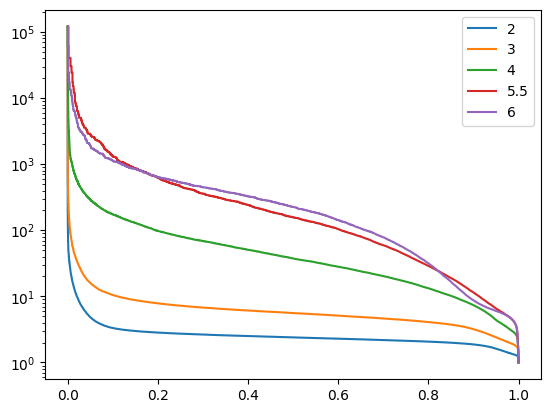

In [64]:
for m in [2, 3, 4, 5.5, 6]:
    something = x_vals_all[np.product(x_vals_all[:,4:6]==[4.5,6],axis=1)==1]
    something[:,4:6]= np.c_[np.ones(len(something)) * m, np.ones(len(something)) * m]
    preds_all_BCE_50 = model_all_BCE.predict(something,batch_size=1000)
    fpr_all_BCE_50, tpr_all_BCE_50, _ = metrics.roc_curve(y_vals_all[np.product(x_vals_all[:,4:6]==[4.5,6],axis=1)==1], preds_all_BCE_50)
    plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))
    #plt.plot(tpr_all_BCE_50, fpr_all_BCE_50)
    plt.legend()
    plt.yscale("log")

In [83]:
np.shape(np.c_[np.ones(len(something)) * 3, np.ones(len(something)) * 3])

(182564, 2)

In [84]:
np.shape(something[:,4:6])

(182564, 2)

In [66]:
preds_all_BCE_100 = model_all_BCE.predict(x_vals_all[np.product(x_vals_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
fpr_all_BCE_100, tpr_all_BCE_100, _ = metrics.roc_curve(y_vals_all[np.product(x_vals_all[:,4:6]==[1,1],axis=1)==1], preds_all_BCE_100)

preds_all_BCE_200 = model_all_BCE.predict(x_vals_all[np.product(x_vals_all[:,4:6]==[2,2],axis=1)==1],batch_size=1000)
fpr_all_BCE_200, tpr_all_BCE_200, _ = metrics.roc_curve(y_vals_all[np.product(x_vals_all[:,4:6]==[2,2],axis=1)==1], preds_all_BCE_200)

preds_all_BCE_300 = model_all_BCE.predict(x_vals_all[np.product(x_vals_all[:,4:6]==[3,3],axis=1)==1],batch_size=1000)
fpr_all_BCE_300, tpr_all_BCE_300, _ = metrics.roc_curve(y_vals_all[np.product(x_vals_all[:,4:6]==[3,3],axis=1)==1], preds_all_BCE_300)

preds_all_BCE_400 = model_all_BCE.predict(x_vals_all[np.product(x_vals_all[:,4:6]==[4,4],axis=1)==1],batch_size=1000)
fpr_all_BCE_400, tpr_all_BCE_400, _ = metrics.roc_curve(y_vals_all[np.product(x_vals_all[:,4:6]==[4,4],axis=1)==1], preds_all_BCE_400)

preds_all_BCE_500 = model_all_BCE.predict(x_vals_all[np.product(x_vals_all[:,4:6]==[5,5],axis=1)==1],batch_size=1000)
fpr_all_BCE_500, tpr_all_BCE_500, _ = metrics.roc_curve(y_vals_all[np.product(x_vals_all[:,4:6]==[5,5],axis=1)==1], preds_all_BCE_500)

preds_all_BCE_600 = model_all_BCE.predict(x_vals_all[np.product(x_vals_all[:,4:6]==[6,6],axis=1)==1],batch_size=1000)
fpr_all_BCE_600, tpr_all_BCE_600, _ = metrics.roc_curve(y_vals_all[np.product(x_vals_all[:,4:6]==[6,6],axis=1)==1], preds_all_BCE_600)

175/175 [==============================] - 0s 679us/step


Text(0.5, 1.0, '$(600,600)$ GeV Dedicated vs Parametrized BCE')

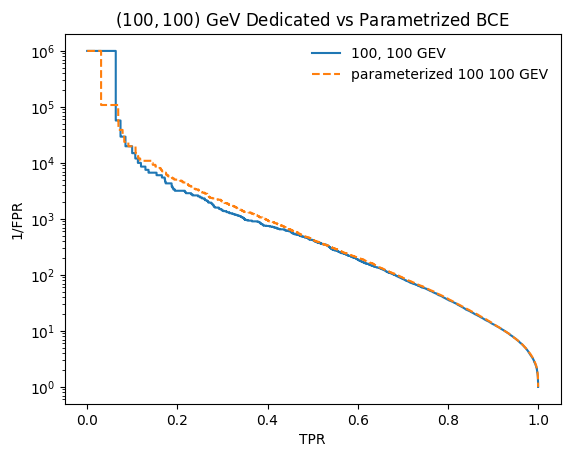

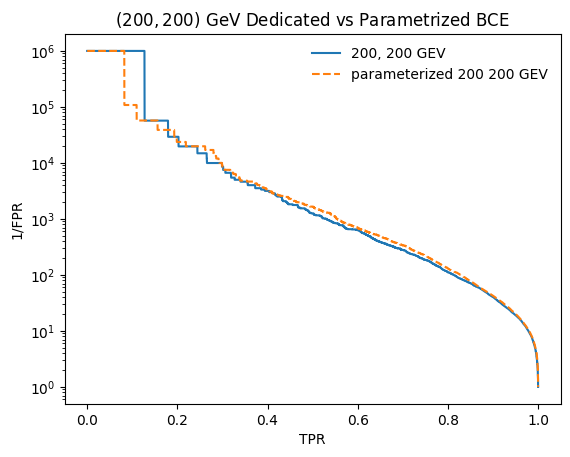

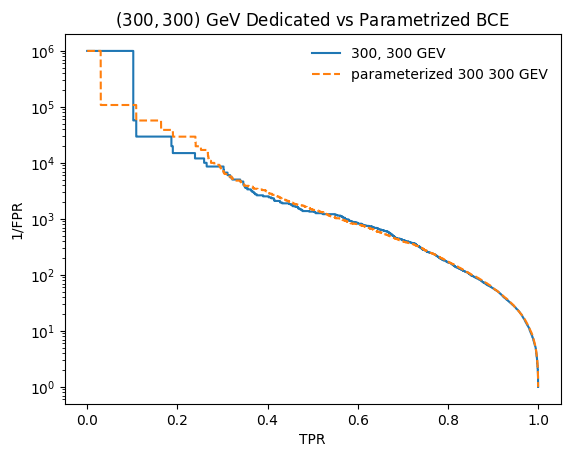

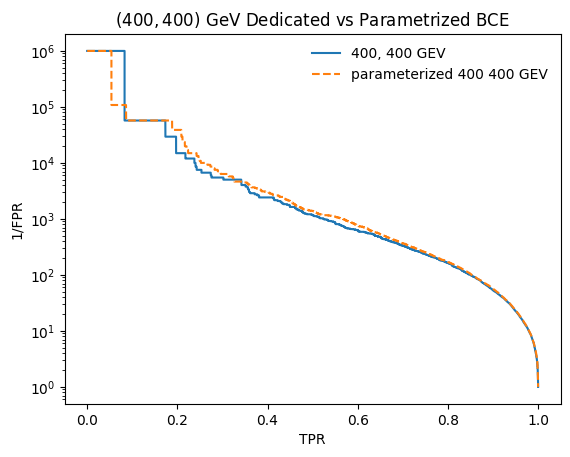

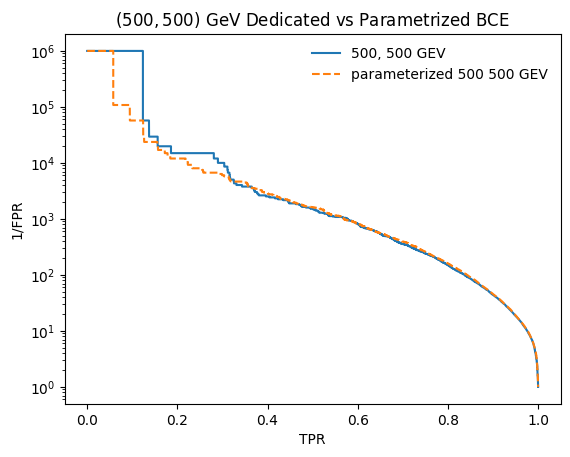

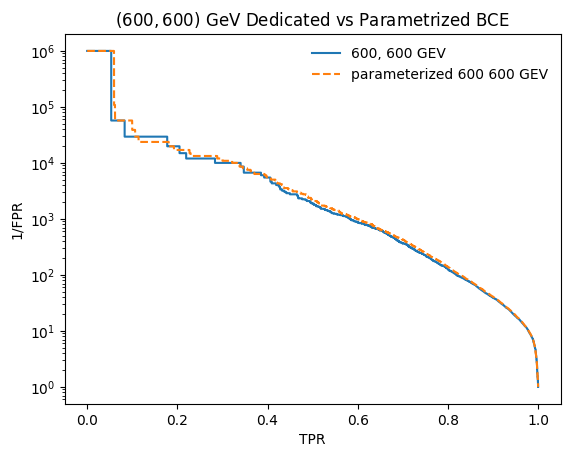

In [85]:
epsilon = 1e-6
plt.figure()
plt.plot(tuple_rates_dedicated[(1,1)][1], 1./(tuple_rates_dedicated[(1,1)][0] + epsilon), label = "100, 100 GEV")
plt.plot(tpr_all_BCE_100, 1./(fpr_all_BCE_100 + epsilon),label="parameterized 100 100 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(100,100)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(2,2)][1], 1./(tuple_rates_dedicated[(2,2)][0] + epsilon), label = "200, 200 GEV")
plt.plot(tpr_all_BCE_200, 1./(fpr_all_BCE_200 + epsilon),label="parameterized 200 200 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(200,200)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(3,3)][1], 1./(tuple_rates_dedicated[(3,3)][0] + epsilon), label = "300, 300 GEV")
plt.plot(tpr_all_BCE_300, 1./(fpr_all_BCE_300 + epsilon),label="parameterized 300 300 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(300,300)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(4,4)][1], 1./(tuple_rates_dedicated[(4,4)][0] + epsilon), label = "400, 400 GEV")
plt.plot(tpr_all_BCE_400, 1./(fpr_all_BCE_400 + epsilon),label="parameterized 400 400 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(400,400)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(5,5)][1], 1./(tuple_rates_dedicated[(5,5)][0] + epsilon), label = "500, 500 GEV")
plt.plot(tpr_all_BCE_500, 1./(fpr_all_BCE_500 + epsilon),label="parameterized 500 500 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(500,500)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(6,6)][1], 1./(tuple_rates_dedicated[(6,6)][0] + epsilon), label = "600, 600 GEV")
plt.plot(tpr_all_BCE_600, 1./(fpr_all_BCE_600 + epsilon),label="parameterized 600 600 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(600,600)$ GeV Dedicated vs Parametrized BCE")

Analysis of Models begins here

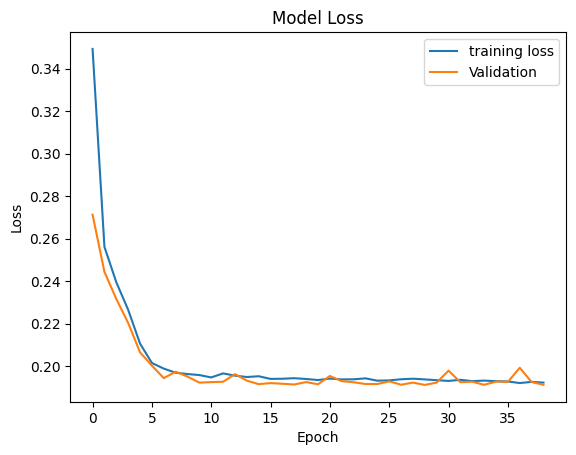

In [153]:
# Plot the training and validation loss
plt.plot(myhistory.history['loss'])
plt.plot(myhistory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'Validation'], loc='upper right')
plt.show()

In [89]:
preds_100 = model.predict(X_val_100,batch_size=1000)
fpr_100, tpr_100, _ = metrics.roc_curve(Y_val_100, preds_100)

99/99 [==============================] - 0s 737us/step


In [121]:
y_val_all_pred = model_all_BCE.predict(X_val_all)
auc_all = roc_auc_score(Y_val_all, y_val_all_pred)

print("AUC:", auc_all)

425773/425773 [==============================] - 301s 707us/step
AUC: 0.98044191324073


In [129]:
preds_all_BCE_51 = model_all_BCE.predict(x_vals_all[np.product(x_vals_all[:,4:6]==[5,1],axis=1)==1],batch_size=1000)
auc_all_51 = roc_auc_score(y_vals_all[np.product(x_vals_all[:,4:6]==[5,1],axis=1)==1], preds_all_BCE_51)

print("AUC:", auc_all_51)

180/180 [==============================] - 0s 856us/step
AUC: 0.97088308745336


In [ ]:
y_val_all_pred = model_all_BCE.predict(X_val_all[:,4:6]==[5,1])
auc_all = roc_auc_score(Y_val_all, y_val_all_pred)

print("AUC:", auc_all)

In [6]:
if (False):
    x_vals_all = []
    y_vals_all = []
    for m1 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            #if m1 >= m2: 
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0],m1*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1),m2*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2],m1*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_vals_all = np.concatenate([x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
            else:
                x_vals_all = np.concatenate([x_vals_all,x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([y_vals_all,np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
    # np.save("x_data_all_fixed",x_vals_all)
    # np.save("y_data_all_fixed",y_vals_all)

0.5 0.5
0.5 1
0.5 1.5
0.5 2
0.5 2.5
0.5 3
0.5 3.5
0.5 4
0.5 4.5
0.5 5
0.5 5.5
0.5 6
1 0.5
1 1
1 1.5
1 2
1 2.5
1 3
1 3.5
1 4
1 4.5
1 5
1 5.5
1 6
1.5 0.5
1.5 1
1.5 1.5
1.5 2
1.5 2.5
1.5 3
1.5 3.5
1.5 4
1.5 4.5
1.5 5
1.5 5.5
1.5 6
2 0.5
2 1
2 1.5
2 2
2 2.5
2 3
2 3.5
2 4
2 4.5
2 5
2 5.5
2 6
2.5 0.5
2.5 1
2.5 1.5
2.5 2
2.5 2.5
2.5 3
2.5 3.5
2.5 4
2.5 4.5
2.5 5
2.5 5.5
2.5 6
3 0.5
3 1
3 1.5
3 2
3 2.5
3 3
3 3.5
3 4
3 4.5
3 5
3 5.5
3 6
3.5 0.5
3.5 1
3.5 1.5
3.5 2
3.5 2.5
3.5 3
3.5 3.5
3.5 4
3.5 4.5
3.5 5
3.5 5.5
3.5 6
4 0.5
4 1
4 1.5
4 2
4 2.5
4 3
4 3.5
4 4
4 4.5
4 5
4 5.5
4 6
4.5 0.5
4.5 1
4.5 1.5
4.5 2
4.5 2.5
4.5 3
4.5 3.5
4.5 4
4.5 4.5
4.5 5
4.5 5.5
4.5 6
5 0.5
5 1
5 1.5
5 2
5 2.5
5 3
5 3.5
5 4
5 4.5
5 5
5 5.5
5 6
5.5 0.5
5.5 1
5.5 1.5
5.5 2
5.5 2.5
5.5 3
5.5 3.5
5.5 4
5.5 4.5
5.5 5
5.5 5.5
5.5 6
6 0.5
6 1
6 1.5
6 2
6 2.5
6 3
6 3.5
6 4
6 4.5
6 5
6 5.5
6 6


In [5]:
x_vals_all = np.load("x_vals_all_fixed.npy")
y_vals_all = np.load("y_vals_all_fixed.npy")

In [12]:
x_vals_all

array([[-1.51676489, -0.61369051, -1.38971753,  0.29771386,  0.5       ,
         0.5       ],
       [-1.36743797, -1.69854625,  0.49237383,  1.25083942,  0.5       ,
         0.5       ],
       [-0.91169568, -1.71429933,  1.16183703,  0.35002242,  0.5       ,
         0.5       ],
       ...,
       [ 1.67050639, -1.47882044, -1.74284539, -0.42126164,  6.        ,
         6.        ],
       [ 1.35240368, -1.31499431, -1.59380349, -2.25775246,  6.        ,
         6.        ],
       [-0.43435266,  0.80463752, -0.30028819, -1.79951517,  6.        ,
         6.        ]])

In [13]:
y_vals_all

array([0., 0., 0., ..., 1., 1., 1.])

In [14]:
np.shape(x_vals_all)

(27249420, 6)

In [21]:
np.shape(x_vals_all)

(14563810, 6)

In [27]:
X_train_all, X_val_all, Y_train_all, Y_val_all = train_test_split(x_vals_all, y_vals_all, test_size=0.5, random_state = 42)

In [23]:
Y_val_all

array([1., 0., 0., ..., 1., 0., 0.])

In [16]:
pscratch_dir = "/pscratch/sd/g/gupsingh"
os.environ["WANDB_DIR"] = pscratch_dir

wandb.init(
    project="Anomaly",
    group="Parametrized",
    entity='gup-singh',
    mode = 'disabled',

    config={
        "layer_1": 128,
        "activation_1": "relu",
        "layer_2": 128,
        "activation_2": "relu",
        "layer_3": 128,
        "activation_3": "relu",
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 1000,
        "batch_size": 1024
    },
    dir = pscratch_dir
)

config_parametrized = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [29]:
model_all = Sequential()
model_all.add(Dense(256, input_dim=6, activation='swish'))
model_all.add(BatchNormalization())
model_all.add(Dense(256, activation='swish'))
model_all.add(BatchNormalization())
model_all.add(Dense(256, activation='swish'))
model_all.add(BatchNormalization())
model_all.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model_all.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

myhistory_all = model_all.fit(X_train_all, Y_train_all, epochs=100,validation_data=(X_data_all, Y_data_all),batch_size=5*1024,callbacks=[es])

Epoch 1/5000
2662/2662 [==============================] - 13s 4ms/step - loss: 0.2881 - accuracy: 0.8866 - val_loss: 0.2432 - val_accuracy: 0.9073
Epoch 2/5000
2662/2662 [==============================] - 11s 4ms/step - loss: 0.2311 - accuracy: 0.9111 - val_loss: 0.2191 - val_accuracy: 0.9152
Epoch 3/5000
2662/2662 [==============================] - 10s 4ms/step - loss: 0.2124 - accuracy: 0.9173 - val_loss: 0.2063 - val_accuracy: 0.9196
Epoch 4/5000
2662/2662 [==============================] - 10s 4ms/step - loss: 0.2025 - accuracy: 0.9209 - val_loss: 0.1990 - val_accuracy: 0.9222
Epoch 5/5000
2662/2662 [==============================] - 10s 4ms/step - loss: 0.1965 - accuracy: 0.9232 - val_loss: 0.1940 - val_accuracy: 0.9243
Epoch 6/5000
2662/2662 [==============================] - 11s 4ms/step - loss: 0.1923 - accuracy: 0.9250 - val_loss: 0.1905 - val_accuracy: 0.9256
Epoch 7/5000
2662/2662 [==============================] - 11s 4ms/step - loss: 0.1891 - accuracy: 0.9262 - val_loss: 0

KeyboardInterrupt: 

In [17]:
model_all = Sequential()
model_all.add(Dense(config_parametrized.layer_1, input_dim=6, activation=config_parametrized.activation_1))
model_all.add(Dense(config_parametrized.layer_2, activation=config_parametrized.activation_2))
model_all.add(Dense(config_parametrized.layer_3, activation=config_parametrized.activation_3))
model_all.add(Dense(config_parametrized.output_layer, activation=config_parametrized.output_activation))
model_all.compile(loss=config_parametrized.loss, optimizer=config_parametrized.optimizer, metrics=['accuracy'])

2023-12-03 02:33:30.556731: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 02:33:31.454976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18791 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [28]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [19]:
with tf.device('/GPU:0'):
    myhistory_all = model_all.fit(X_train_all, Y_train_all, epochs=config_parametrized.epoch,validation_data=(X_val_all, Y_val_all),batch_size=config_parametrized.batch_size*5, callbacks = [WandbCallback(), es])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/1000
  37/2662 [..............................] - ETA: 12s - loss: 0.4137 - accuracy: 0.7956  

2023-12-03 02:33:37.849259: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2662/2662 [==============================] - 23s 8ms/step - loss: 0.1946 - accuracy: 0.9233 - val_loss: 0.1750 - val_accuracy: 0.9315
Epoch 2/1000
2662/2662 [==============================] - 17s 6ms/step - loss: 0.1726 - accuracy: 0.9323 - val_loss: 0.1723 - val_accuracy: 0.9321
Epoch 3/1000
2662/2662 [==============================] - 17s 7ms/step - loss: 0.1703 - accuracy: 0.9330 - val_loss: 0.1704 - val_accuracy: 0.9329
Epoch 4/1000
2662/2662 [==============================] - 17s 6ms/step - loss: 0.1696 - accuracy: 0.9333 - val_loss: 0.1698 - val_accuracy: 0.9331
Epoch 5/1000
2662/2662 [==============================] - 18s 7ms/step - loss: 0.1691 - accuracy: 0.9335 - val_loss: 0.1705 - val_accuracy: 0.9329
Epoch 6/1000
2662/2662 [==============================] - 19s 7ms/step - loss: 0.1688 - accuracy: 0.9335 - val_loss: 0.1691 - val_accuracy: 0.9334
Epoch 7/1000
2662/2662 [==============================] - 21s 8ms/step - loss: 0.1685 - accuracy: 0.9337 - val_loss: 0.1698 - val_a

In [29]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▇▇▇███████████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▄▅▆▆▇▇▇▇█▇▇▇█▇█▇▇▇████▇███▇█
val_loss,█▅▄▅▄▃▃▂▂▂▂▁▂▂▂▁▂▁▂▂▂▁▁▁▁▂▁▁▁▂▁
accuracy,0.9362
best_epoch,26
best_val_loss,0.16208
epoch,30
loss,0.1622
val_accuracy,0.93596


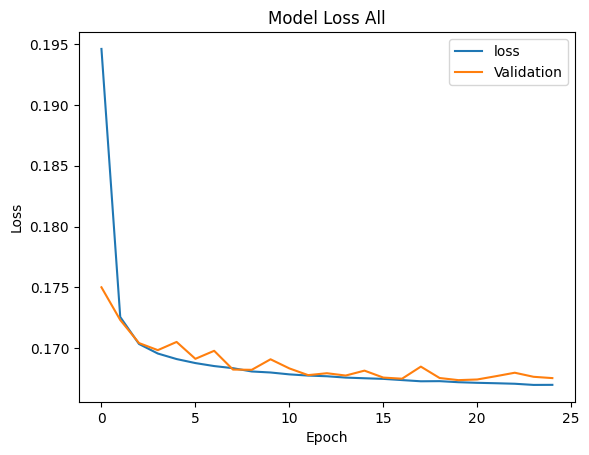

In [21]:
plt.plot(myhistory_all.history['loss'])
plt.plot(myhistory_all.history['val_loss'])
plt.title('Model Loss All')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'Validation'], loc='upper right')
plt.show()

In [129]:
preds_all_BCE = model_all.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
fpr_all_BCE, tpr_all_BCE, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_BCE)

100/100 [==============================] - 0s 690us/step


In [130]:
preds_100_BCE = model_dedicated.predict(X_val_100,batch_size=1000)
fpr_100_BCE, tpr_100_BCE, _ = metrics.roc_curve(Y_val_100, preds_100_BCE)

99/99 [==============================] - 0s 675us/step


/tmp/ipykernel_808700/2993218434.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_100_BCE,1./(fpr_100_BCE),label="dedicated_100")
/tmp/ipykernel_808700/2993218434.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE,1./(fpr_all_BCE),label="parameterized_100")


Text(0.5, 1.0, '$(m_B,m_C) = (100,100)$ GeV Dedicated BCE vs Parametrized BCE (Optimized)')

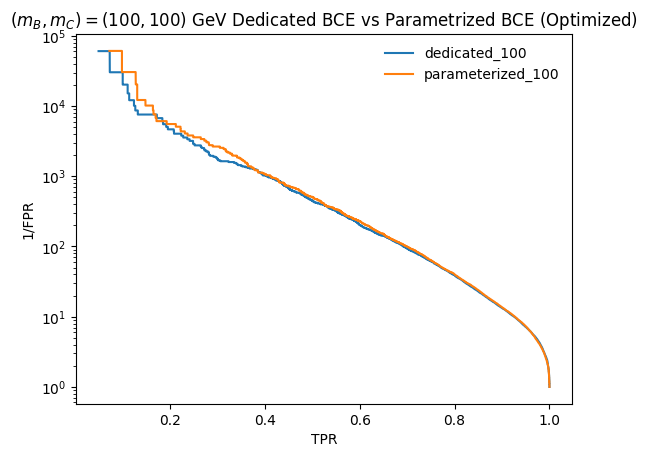

In [131]:
epsilon = 1e-6
plt.plot(tpr_100_BCE,1./(fpr_100_BCE),label="dedicated_100")
plt.plot(tpr_all_BCE,1./(fpr_all_BCE),label="parameterized_100")

plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_B,m_C) = (100,100)$ GeV Dedicated BCE vs Parametrized BCE (Optimized)")

In [93]:
xx = []
mm = []
for m1 in mass_range[1:]:
        for m2 in mass_range[1:]:

            #freeze layers
            for l in model_all.layers:
                l.trainable=False

            #create simple models
            model3 = createSimpleModel(1)
            model32 = createSimpleModel(4)

            #combine everything
            inputs = tf.keras.Input(shape=(4,))
            inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
            hidden_layer_1 = model_all(inputs2)
            model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
            model_all2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

            x_data_ = np.concatenate([x[0,0],x[m1,m2]])
            y_data_ = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[m1,m2]))])
            X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5)
            myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)
            print(m1,m2,np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1])
            xx += [[np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1]]]
            mm += [[m1,m2]]

0.5 0.5 0.54886675 9.1187
0.5 1 1.178339 9.041979
0.5 1.5 1.7308723 9.9712
0.5 2 0.65783334 12.198997
0.5 2.5 0.522094 2.493953
0.5 3 0.5387169 3.0016263
0.5 3.5 0.5234309 3.4909031
0.5 4 0.52216065 4.001814
0.5 4.5 0.5345104 4.51066
0.5 5 0.5427123 4.992942
0.5 5.5 0.5428319 5.498277
0.5 6 0.53163356 5.998263
1 0.5 1.1933674 9.145726
1 1 1.0703924 8.500084
1 1.5 1.132519 9.325226
1 2 1.0354787 2.0043766
1 2.5 1.0316507 2.5240946
1 3 1.0704712 3.0058718
1 3.5 1.0580518 3.4873185
1 4 1.0528803 3.9906034
1 4.5 1.0393144 4.5107846
1 5 1.0346998 5.0036116
1 5.5 1.0566307 5.5142756
1 6 1.0626242 6.0140896
1.5 0.5 1.7387886 10.043673
1.5 1 1.117349 9.313453
1.5 1.5 1.5716422 8.922293
1.5 2 1.5382792 2.0096004
1.5 2.5 1.5484798 2.5378559
1.5 3 1.5439345 3.0212643
1.5 3.5 1.5301502 3.5112069
1.5 4 1.5580177 4.0056057
1.5 4.5 1.5548168 4.5293093
1.5 5 1.5739219 5.0092616
1.5 5.5 1.5660185 5.5184603
1.5 6 1.557921 6.019687
2 0.5 0.653705 12.106312
2 1 1.0576507 2.006056
2 1.5 1.5467144 2.0206738

In [ ]:
len(x[m1,m2])

In [94]:
xx = np.array(xx)
mm = np.array(mm)

found_both = 0.
found_one = 0.
found_none = 0.
for i in range(len(mm)):
    diff1 = abs(mm[i][0]-xx[i][0])
    diff2 = abs(mm[i][1]-xx[i][0])
    diff3 = abs(mm[i][0]-xx[i][1])
    diff4 = abs(mm[i][1]-xx[i][1])
    diffs = [diff1,diff2,diff3,diff4]
    if (diff1 < 0.2 and diff4 < 0.2) or (diff2 < 0.2 and diff3 < 0.2):
        #print(mm[i],xx[i])
        found_both+=1
    elif (min(diffs) < 0.2):
        print(mm[i],xx[i])
        found_one+=1
        pass
    else:
        print(mm[i],xx[i])
        found_none+=1
        pass

print("found both:",found_both/(found_both+found_one+found_none))
print("found one:",found_one/(found_both+found_one+found_none))
print("found none:",found_none/(found_both+found_one+found_none))

[0.5 0.5] [0.54886675 9.1187    ]
[0.5 1. ] [1.178339 9.041979]
[0.5 1.5] [1.7308723 9.9712   ]
[0.5 2. ] [ 0.65783334 12.198997  ]
[1.  0.5] [1.1933674 9.145726 ]
[1. 1.] [1.0703924 8.500084 ]
[1.  1.5] [1.132519 9.325226]
[1.5 0.5] [ 1.7387886 10.043673 ]
[1.5 1. ] [1.117349 9.313453]
[1.5 1.5] [1.5716422 8.922293 ]
[2.  0.5] [ 0.653705 12.106312]
[5.5 0.5] [0.2294059 5.4994617]
[6.  0.5] [0.19844559 6.0047936 ]
found both: 0.9097222222222222
found one: 0.0763888888888889
found none: 0.013888888888888888


In [30]:
model_all = tf.keras.models.load_model("model_all_BCE")
#model_all_MSE = tf.keras.models.load_model("model_all_MSE")

2023-12-23 18:40:54.115039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-23 18:40:54.927181: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [53]:
sig_list = []
weight_list1 = []
weight_list2 = []
weight_list3 = []

max_sic1 = []
max_sic2 = []

epsilon = 1e-4

# w1 = round(random.uniform(0.5, 6.0),3)
# w2 = round(random.uniform(0.5, 6.0),3)

w1 = 3.241
w2 = 3.649

for sigfrac in np.logspace(-3,-1,20):
    #sigfrac = 0.07
    print(w1, w2, sigfrac)

    for l in model_all.layers:
        l.trainable=False

    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + 0.0001)
    #LLR_xs = 1.+sigfrac*LLR - sigfrac
    LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0])*LLR
    ws = LLR_xs / (1.+LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

    m1 = 3
    m2 = 3

    test_background = int(1/2 * len(x[0,0]))
    train_reference = int(1/4 *len(x[0,0]))
    train_data = int(1/4 * len(x[0,0]))
    test_signal = int(1/2*len(x[m1,m2]))

    N = int(1/4 *len(x[0,0]))
    x_data_ = np.concatenate([x[0,0][test_background:],x[m1,m2][test_signal:test_signal+int(sig_frac*N)]])
    y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(x[m1,m2][test_signal:test_signal+int(sig_frac*N)]))])

    print(N,len(x[0,0])-N,len(x[m1,m2][0:int(sig_frac*N)]),len(x[m1,m2][0:int(sig_frac*N)])/N)

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)
    print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
    sig_list+=[sigfrac]
    weight_list1+=[model_all2.trainable_weights[0].numpy()[0][0]]
    weight_list2+=[model_all2.trainable_weights[1].numpy()[0][0]]
    weight_list3+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
    # scores = model_all2.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal]]),batch_size=1024)
    # y = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
    # fpr, tpr, _ = metrics.roc_curve(y, scores)

    #weakly supervised
    # model_cwola = Sequential()
    # model_cwola.add(Dense(128, input_dim=4, activation='relu'))
    # model_cwola.add(Dense(128, activation='relu'))
    # model_cwola.add(Dense(128, activation='relu'))
    # model_cwola.add(Dense(1, activation='sigmoid'))
    # model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)

    # scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal]]),batch_size=1024)
    # y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
    # fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    # plt.plot(tpr,tpr/np.sqrt(fpr))
    # plt.plot(tpr2,tpr2/np.sqrt(fpr2))

    # msic1.append([np.max(tpr/np.sqrt(fpr+0.0001))])
    # msic2.append([np.max(tpr2/np.sqrt(fpr2+0.0001))])


    #fully supervised
#     model3_full = createSimpleModel(w1)
#     model32_full = createSimpleModel(w2)

#     inputs = tf.keras.Input(shape=(4,))
#     inputs2_full = tf.keras.layers.concatenate([inputs,model3_full(tf.ones_like(inputs)[:,0]),model32_full(tf.ones_like(inputs)[:,0])])
#     hidden_layer_1_full = model_all(inputs2_full)
#     model_all2_full = Model(inputs = inputs, outputs = hidden_layer_1_full)
#     model_all2_full.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

#     x_data_full = np.concatenate([x[0,0],x[m1,m2]])
#     y_data_full = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[m1,m2]))])
#     X_train_full, X_val_full, Y_train_full, Y_val_full = train_test_split(x_data_full, y_data_full, test_size=0.5)
#     myhistory_hack_ = model_all2_full.fit(X_train_full[:,0:4], Y_train_full, epochs=20,validation_data=(X_val_full[:,0:4], Y_val_full),batch_size=1024, verbose = 0)

#     scores_full = model_all2_full.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:random_test_signal_length]]),batch_size=1024)
#     y_full = np.concatenate([np.zeros(test_background),np.ones(random_test_signal_length)])
#     fpr_full, tpr_full, _ = metrics.roc_curve(y_full, scores_full)

#     msic3.append([np.max(tpr_full/np.sqrt(fpr_full+0.0001))])

3.241 3.649 0.001
30338 91014 30 0.0009888588568791614
3 3 3.1579924 3.1172059
3.241 3.649 0.0012742749857031334
30338 91014 38 0.0012525545520469378
3 3 3.1826441 3.087931
3.241 3.649 0.001623776739188721
30338 91014 49 0.0016151361329026304
3 3 3.1388724 3.8904655
3.241 3.649 0.00206913808111479
30338 91014 62 0.002043641637550267
3 3 3.154447 3.0509462
3.241 3.649 0.0026366508987303583
30338 91014 79 0.002603994989781792
3 3 3.1705275 3.0789962
3.241 3.649 0.003359818286283781
30338 91014 101 0.003329158151493177
3 3 3.1876981 3.0938199
3.241 3.649 0.004281332398719396
30338 91014 129 0.004252093084580394
3 3 3.1321526 3.831782
3.241 3.649 0.00545559478116852
30338 91014 165 0.005438723712835388
3 3 3.1570003 3.0416594
3.241 3.649 0.0069519279617756054
30338 91014 210 0.00692201199815413
3 3 3.1844287 3.087246
3.241 3.649 0.008858667904100823
30338 91014 268 0.008833805788120508
3 3 3.1365278 3.029059
3.241 3.649 0.011288378916846888
30338 91014 342 0.011272990968422441
3 3 3.148054

In [1]:
plt.plot(sig_list, weight_list3, marker = "x", label='Semi Weakly', color='blue')
plt.plot(sig_list, sig_list, marker = "", label='S/B', color='black')
plt.xlabel('S/B')
plt.ylabel(r'Fitted S/B')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [41]:
from models import createSimpleModel

msic1_runs = []
msic2_runs = []
msic3_runs = []
weight_list3_runs = []
initial_weights_list_runs = []

num_runs = 5
feature_dims = 4

for _ in range(num_runs):
    
    sig_list = []
    weight_list1 = []
    weight_list2 = []
    weight_list3 = []
    
    msic1 = []
    msic2 = []
    msic3 = []

    epsilon = 1e-4

    # w1 = round(random.uniform(0.5, 6.0),3)
    # w2 = round(random.uniform(0.5, 6.0),3)

    w1 = 3.241
    w2 = 3.649
    
    initial_weights_list_runs.append((w1, w2))

    for sigfrac in np.logspace(-3,-1,20):
        print(w1, w2, sigfrac)
        #sigfrac = 0.05

        for l in model_all.layers:
            l.trainable=False

        inputs_hold = tf.keras.Input(shape=(1,))
        simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
        model3 = Model(inputs = inputs_hold, outputs = simple_model)

        inputs_hold2 = tf.keras.Input(shape=(1,))
        simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
        model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

        inputs_hold3 = tf.keras.Input(shape=(1,))
        simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
        model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

        inputs = tf.keras.Input(shape=(feature_dims,))
        inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
        
        #physics prior
        hidden_layer_1 = model_all(inputs2)
        LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
        
        #LLR_xs = 1.+sigfrac*LLR - sigfrac
        LLR_xs = 1.+ model33(tf.ones_like(inputs)[:,0])*LLR
        ws = LLR_xs / (1.+LLR_xs)
        
        model_all2 = Model(inputs = inputs, outputs = ws)
        model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

        m1 = 3
        m2 = 3

        test_background = int(1/2 * len(x[0,0]))
        train_reference = int(1/4 *len(x[0,0]))
        train_data = int(1/4 * len(x[0,0]))
        test_signal = int(1/2*len(x[m1,m2]))
        
        #randomize signal events
        random_test_signal_length = random.randint(0, test_signal - 1)
        N = int(1/4 * (len(x[0,0])))
        signal = x[m1, m2][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

        #N = train_reference
        x_data_ = np.concatenate([x[0,0][test_background:],signal])
        y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

        X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

        myhistory_hack_ = model_all2.fit(X_train_[:,0:feature_dims], Y_train_, epochs=100,validation_data=(X_val_[:,0:feature_dims], Y_val_),batch_size=1024, verbose = 0)
        print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
        sig_list+=[sigfrac]
        weight_list1+=[model_all2.trainable_weights[0].numpy()[0][0]]
        weight_list2+=[model_all2.trainable_weights[1].numpy()[0][0]]
        weight_list3+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
        scores = model_all2.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal]]),batch_size=1024)
        y = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
        fpr, tpr, _ = metrics.roc_curve(y, scores)
        
        #weakly supervised
        model_cwola = Sequential()
        model_cwola.add(Dense(128, input_dim=feature_dims, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(1, activation='sigmoid'))
        model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        myhistory_cwola = model_cwola.fit(X_train_[:,0:feature_dims], Y_train_, epochs=10,validation_data=(X_val_[:,0:feature_dims], Y_val_),batch_size=1024, verbose = 0)

        scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal]]),batch_size=1024)
        y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
        fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
        
        #fully supervised
        model3_full = createSimpleModel(m1)
        model32_full = createSimpleModel(m2)

        inputs = tf.keras.Input(shape=(feature_dims,))
        inputs2_full = tf.keras.layers.concatenate([inputs,model3_full(tf.ones_like(inputs)[:,0]),model32_full(tf.ones_like(inputs)[:,0])])
        hidden_layer_1_full = model_all(inputs2_full)
        model_all2_full = Model(inputs = inputs, outputs = hidden_layer_1_full)
        model_all2_full.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

        x_data_full = np.concatenate([x[0,0],x[m1,m2]])
        y_data_full = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[m1,m2]))])
        X_train_full, X_val_full, Y_train_full, Y_val_full = train_test_split(x_data_full, y_data_full, test_size=0.5)
        myhistory_hack_ = model_all2_full.fit(X_train_full[:,0:feature_dims], Y_train_full, epochs=20,validation_data=(X_val_full[:,0:feature_dims], Y_val_full),batch_size=1024, verbose = 0)

        scores_full = model_all2_full.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:random_test_signal_length]]),batch_size=1024)
        y_full = np.concatenate([np.zeros(test_background),np.ones(random_test_signal_length)])
        fpr_full, tpr_full, _ = metrics.roc_curve(y_full, scores_full)
        
        # plt.plot(tpr,tpr/np.sqrt(fpr))
        # plt.plot(tpr2,tpr2/np.sqrt(fpr2))

        msic1.append([np.max(tpr/np.sqrt(fpr+0.0001))])
        msic2.append([np.max(tpr2/np.sqrt(fpr2+0.0001))])
        msic3.append([np.max(tpr_full/np.sqrt(fpr_full+0.0001))])

    msic1_runs.append(msic1)
    msic2_runs.append(msic2)
    msic3_runs.append(msic3)
    weight_list3_runs.append(weight_list3)

3.241 3.649 0.001
30338 91014 30 0.0009888588568791614
3 3 3.1192825 2.9902208
69/69 [==============================] - 0s 723us/step
3.241 3.649 0.0012742749857031334
30338 91014 38 0.0012525545520469378
3 3 3.1106145 3.0138872
88/88 [==============================] - 0s 678us/step
3.241 3.649 0.001623776739188721
30338 91014 49 0.0016151361329026304
3 3 3.078006 2.9729447
95/95 [==============================] - 0s 685us/step
3.241 3.649 0.00206913808111479
30338 91014 62 0.002043641637550267
3 3 3.0807834 2.9750807
89/89 [==============================] - 0s 766us/step
3.241 3.649 0.0026366508987303583
30338 91014 79 0.002603994989781792
3 3 3.1383238 2.9480364
77/77 [==============================] - 0s 746us/step
3.241 3.649 0.003359818286283781
30338 91014 101 0.003329158151493177
3 3 3.1465135 3.0562773
84/84 [==============================] - 0s 753us/step
3.241 3.649 0.004281332398719396
30338 91014 129 0.004252093084580394
3 3 3.0576751 2.9848797
82/82 [======================

In [81]:
("FS",m1, m2, w1, w2)

('FS', 3, 3, 3.241, 3.649)

In [84]:
np.save("4Features3Param33Perturb_WEIGHTLIST",ww_runs)

In [82]:
max_sics = {}
max_sics[("SWS", 3, m1, m2, w1, w2)] = msic1_runs
max_sics[("WS", 3, m1, m2, w1, w2)] = msic2_runs
max_sics[("FS", 3, m1, m2, w1, w2)] = msic3_runs

In [83]:
import pickle
with open('max_sics_33_3param.pkl', 'wb') as f:
    pickle.dump(max_sics, f)

In [66]:
with open('max_sics_33.pkl', 'rb') as f:
    loaded_max_sics = pickle.load(f)

loaded_array = loaded_max_sics[("SWS", 3, 3, 3.241, 3.649)]

Text(0, 0.5, 'Avg Max SIC')

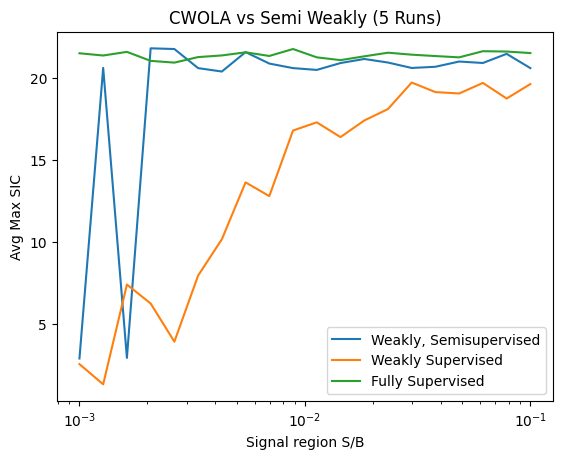

In [78]:
avgmsic1 = np.median(msic1_runs, axis = 0)
avgmsic2 = np.median(msic2_runs, axis = 0)
avgmsic3 = np.median(msic3_runs, axis = 0)

# avgsic1 = np.mean(sic1_list_runs, axis = 0)
# avgsic2 = np.mean(sic2_list_runs, axis = 0)

plt.plot(sig_list,avgmsic1,label="Weakly, Semisupervised")
plt.plot(sig_list,avgmsic2,label="Weakly Supervised")
plt.plot(sig_list,avgmsic3,label="Fully Supervised")
plt.title(f"CWOLA vs Semi Weakly ({num_runs} Runs)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

(0.0, 700.0)

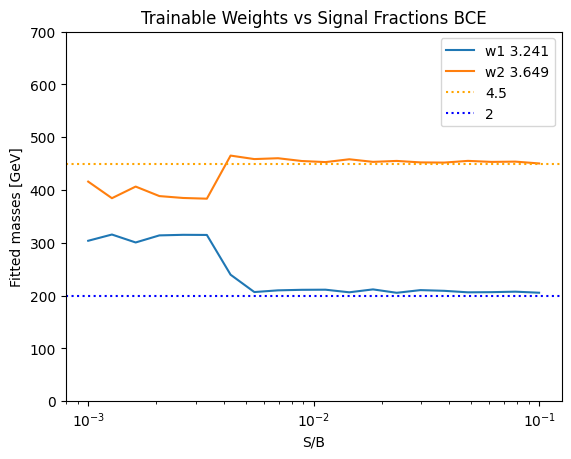

In [36]:
plt.plot(sig_list,np.array(weight_list1)*100, label = f"w1 {w1}")
plt.plot(sig_list,np.array(weight_list2)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions BCE")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])

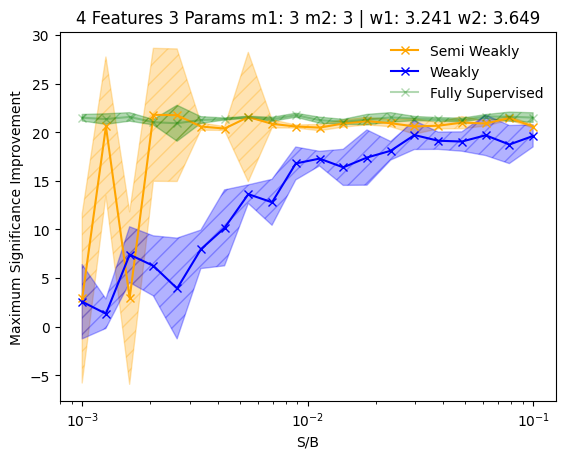

In [79]:
sig_space = np.logspace(-3, -1, 20)
signal_fraction_values = sig_space

maxsic1 = [i[0] for i in avgmsic1]
msicstds1 = np.std(msic1_runs, axis = 0)
maxsicstd1 = np.array([i[0] for i in msicstds1])

maxsic2 = [i[0] for i in avgmsic2]
msicstds2 = np.std(msic2_runs, axis = 0)
maxsicstd2 = np.array([i[0] for i in msicstds2])

maxsic3 = [i[0] for i in avgmsic3]
msicstds3 = np.std(msic3_runs, axis = 0)
maxsicstd3 = np.array([i[0] for i in msicstds3])

plt.plot(signal_fraction_values, maxsic1, marker = "x", label='Semi Weakly', color='orange')
plt.plot(signal_fraction_values, maxsic2, marker = "x", label='Weakly', color='blue')
plt.plot(signal_fraction_values, maxsic3, marker = "x", label='Fully Supervised', color='green', alpha = 0.3)

plt.fill_between(signal_fraction_values, maxsic1 - maxsicstd1, maxsic1 + maxsicstd1, color='orange', alpha=0.3, hatch = "//")
plt.fill_between(signal_fraction_values, maxsic2 - maxsicstd2, maxsic2 + maxsicstd2, color='blue', alpha=0.3, hatch = "//")
plt.fill_between(signal_fraction_values, maxsic3 - maxsicstd3, maxsic3 + maxsicstd3, color='green', alpha=0.3, hatch = "//")

plt.xlabel('S/B')
plt.ylabel('Maximum Significance Improvement')
plt.title(f'4 Features 3 Params m1: {m1} m2: {m2} | w1: {w1} w2: {w2}')
plt.xscale("log")
plt.legend(frameon= False)
plt.savefig('plot.png', dpi=450, bbox_inches='tight')
plt.show()

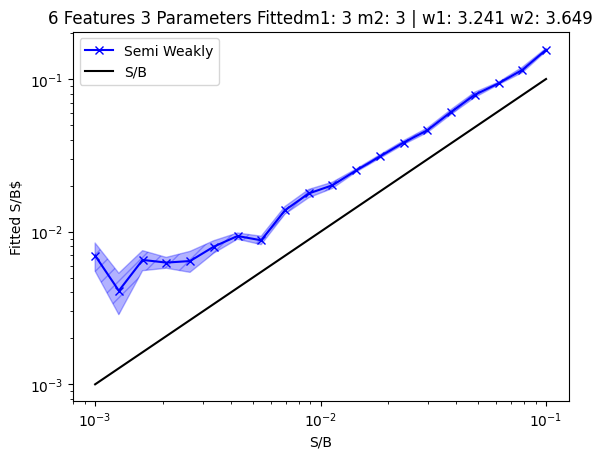

In [80]:
signal_fraction_values = np.logspace(-3, -1, 20)
avgww = np.median(ww_runs, axis = 0)

fittedw = avgww
fittedwstd = np.std(ww_runs, axis = 0)

plt.plot(signal_fraction_values, fittedw, marker = "x", label='Semi Weakly', color='blue')
plt.plot(xx, xx, marker = "", label='S/B', color='black')

plt.fill_between(signal_fraction_values, fittedw - fittedwstd, fittedw + fittedwstd, color='blue', alpha=0.3, hatch = "//")

plt.xlabel('S/B')

plt.ylabel(r'Fitted S/B$')
plt.title(f'6 Features 3 Parameters Fittedm1: {m1} m2: {m2} | w1: {w1} w2: {w2}')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [116]:
import time
start_time = time.time()

def create_loss_landscape_4Features(model, m1, m2):
    
    Nfeatures = 4
    #check if loss dictionary exists, if it does load it, if not create empty one
    dir_path = os.getcwd()
    file_name = f"z_allm1m2_{Nfeatures}FeaturesHD.npy"
    file_path = os.path.join(dir_path, file_name)
    
    if os.path.exists(file_path):
        z = np.load(file_name, allow_pickle = True).item()
    else:
        print("Dictionary doesn't exist, creating one...")
        z = {}
    
    losses_list = []

    epsilon = 1e-6
    sig_space = np.logspace(-3, -1, 20)
    
    #if we want a specific sigfrac
    #sig_space = [sig_space[15]]
    
    start = 0.5
    end = 6
    step = 0.25

    weight_list = np.arange(start, end + step, step)
    
    for sig in sig_space:
            
        print("Signal Fraction: ", sig)
        for w1 in weight_list:
            for w2 in weight_list:
                
                #print(w1, w2)
                sigfrac = sig
                
                for l in model.layers:
                    l.trainable=False

                inputs_hold = tf.keras.Input(shape=(1,))
                simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
                model3 = Model(inputs = inputs_hold, outputs = simple_model)

                inputs_hold2 = tf.keras.Input(shape=(1,))
                simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
                model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

                inputs_hold3 = tf.keras.Input(shape=(1,))
                simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
                model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

                inputs = tf.keras.Input(shape=(Nfeatures,))
                inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
                hidden_layer_1 = model(inputs2)
                LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
                LLR_xs = 1.+sigfrac*LLR - sigfrac
                #LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
                ws = LLR_xs / (1.+LLR_xs+0.0001)
                model_all2 = Model(inputs = inputs, outputs = ws)
                model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

                m1 = m1
                m2 = m2
                
                key = (sig,m1,m2)
                if key in z:
                    break

                test_background = int(1/2 *len(x[0,0]))
                train_background = int(1/4 * len(x[0,0]))
                train_data = int(1/4 * len(x[0,0]))
                train_reference = int(1/4 * len(x[0,0]))
                #signal
                test_signal_length = int(1/2*len(x[m1,m2]))
                sig_frac = sigfrac

                #randomize signal events
                #random_test_signal_length = random.randint(0, test_signal_length - 1)
                N = int(1/4 * (len(x[0,0])))
                signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

                x_data_ = np.concatenate([x[0,0][test_background:],signal])
                y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

                X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

                with tf.device('/GPU:0'):
                    loss = model_all2.evaluate(X_val_, Y_val_, verbose = 0)
                losses_list.append(loss)
                
        end_time = time.time()
        elapsed_time = round(end_time - start_time, 3)
        print(f"Time taken: {elapsed_time} seconds")
        if key in z:
            print("Landscape for m1 = {} ".format(m1) + "and " + "m2 = {} ".format(m2) +" already exists for " + "{}".format(sigfrac) + " signal fraction")
        else:
            z[sigfrac, m1, m2] = losses_list
            losses_list = []
            np.save(file_name, z)
end_time_total = time.time()

elapsed_time_total = round(end_time_total - start_time, 3)
print(f"Total elapsed time: {elapsed_time_total} seconds")

Total elapsed time: 0.001 seconds


In [118]:
create_loss_landscape_4Features(model_all, 3, 3)

Signal Fraction:  0.001
Time taken: 4241.111 seconds
Landscape for m1 = 3 and m2 = 3  already exists for 0.001 signal fraction
Signal Fraction:  0.0012742749857031334
Time taken: 4242.613 seconds
Landscape for m1 = 3 and m2 = 3  already exists for 0.0012742749857031334 signal fraction
Signal Fraction:  0.001623776739188721
Time taken: 4244.133 seconds
Landscape for m1 = 3 and m2 = 3  already exists for 0.001623776739188721 signal fraction
Signal Fraction:  0.00206913808111479
Time taken: 4245.665 seconds
Landscape for m1 = 3 and m2 = 3  already exists for 0.00206913808111479 signal fraction
Signal Fraction:  0.0026366508987303583
Time taken: 4247.195 seconds
Landscape for m1 = 3 and m2 = 3  already exists for 0.0026366508987303583 signal fraction
Signal Fraction:  0.003359818286283781
Time taken: 4248.722 seconds
Landscape for m1 = 3 and m2 = 3  already exists for 0.003359818286283781 signal fraction
Signal Fraction:  0.004281332398719396
Time taken: 4250.248 seconds
Landscape for m1 =